In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm

**MLP with a single hidden layer**

Consider a regression analysis dataset with two features and 1000 non-linear samples in 2D. Train a Multi-layer perceptron (MLP) with a single hidden layer for this regression task.

In [2]:
# data set creation

rng = np.random.default_rng(seed=43)
N = 1000

# Generate two features uniformly between [-1, 1]
X1 = rng.uniform(-1, 1, N)
X2 = rng.uniform(-1, 1, N)

# Generate non-linear target variable with some noise
epsilon = rng.normal(0, 0.2, N)  # Gaussian noise
Y = 3 * np.sin(np.pi * X1) + 2 * np.cos(np.pi * X2) + 0.5 * X1**2 + 0.3 * X2**3 + epsilon

# Create DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'Y': Y})
df.head()

,X1,X2,Y
0,0.304599,-0.783155,1.058676
1,-0.912449,0.462159,-0.544019
2,-0.959941,0.099209,2.007910
3,0.678425,-0.323466,3.878022
4,0.174286,0.735970,0.095776


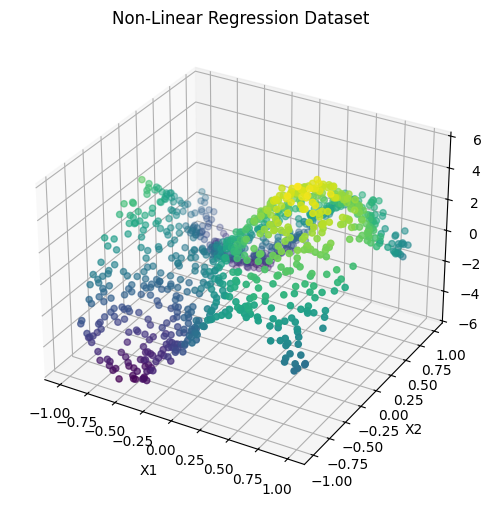

In [3]:
#plot the data

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, Y, c=Y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.set_title('Non-Linear Regression Dataset')

plt.show();

In [4]:
def sigmoid(s):
  """
  Input can be a scalar, vector, or a matrix. It applies the logistic function element-wise.
  """
  return 1 / (1+ np.exp(-s))

# let's define each layer and then put them in the right order to form a network
# the Sigmoid Layer

class Sigmoid():
  def forward(self, input):
    """
    Apply sigmoid to each element of the input,
    and save the results to use in backpropagation.

    input: shape (h,)
    Returns: shape (h,) where h is the number of neurons in the layer

    """
    self.sigmoids = sigmoid(input)
    return self.sigmoids

  def backward(self, gradient):
    """
    compute the downstream gradient by multiplying the upstream and the local gradient element-wise.
    gradient: shape (h, )
    Returns: shape (h, )
    """
    up_grad = gradient

    local_grad = self.sigmoids * (1-self.sigmoids)
    down_grad = up_grad * local_grad  #Hadamard product
    return down_grad

  def params(self):
      return ()

  def grads(self):
      return ()

In [5]:
# the linear layer
class Linear():
  def __init__(self, input_dim, output_dim, w, b):
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.w = w
    self.b = b

  def forward(self, input):
    """
    Computes the forward pass for a single data point.
    input: shape (n, ) where n is the number of input features
    Returns: shape (h, ), where h is the number of neurons in the layer
    """

    # save the input to use in the backward pass
    self.input = input

    s = self.w @ self.input + self.b # (h, n) * (n, ) + (h,)
    return s

  def backward(self, gradient):
    """
    Computes gradients for a single data point.
    gradient: shape (h, )
    Returns: shape (n, )
    """

    up_grad = gradient
    #print(f'Gradient flow: {gradient}')

    local_grad = self.w.T
    down_grad = local_grad @ up_grad # (n,h) * (h,) = (n,)

    self.b_grad = gradient # (h,)
    self.w_grad = np.outer(up_grad, self.input) # (h,) * (n,) = (h,n)

    return down_grad

  def params(self):
    return [self.w, self.b]

  def grads(self):
    return [self.w_grad, self.b_grad]

In [6]:
# building the network

class Sequential():
  def __init__(self, layers):
    self.layers = layers

  def forward(self, input):
    """ Just forward the input through the layers in order. """
    for layer in self.layers:
      input = layer.forward(input)
    return input

  def backward(self, gradient):
    """Backpropagate the gradient through the layers in reverse. """
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    return gradient

  def params(self):
    """Returns the params from each layer. """
    return (param for layer in self.layers for param in layer.params())

  def grads(self):
    """Returns the grads with respect to the parameters from each layer. """
    return (grad for layer in self.layers for grad in layer.grads())


In [7]:
class SSE():
  """ Loss function that computes the sum of the squared errors."""

  def loss(self, y_pred, y_actual):
    """
    Comptue the SSE loss.
    y_pred: (1,)
    y_actual: (1,)
    Returns: scalar
    """

    return np.sum((y_actual - y_pred) ** 2)

  def gradient(self, y_pred, y_actual):
    """
    Comptue the SSE loss.
    y_pred: (1,)
    y_actual: (1,)
    Returns: (1,)
    """

    return 2 * (y_pred - y_actual)


In [8]:
# Gradient descent optimizer

class GradientDescent():
  def __init__(self, lr=0.01):
    self.lr = lr

  def step(self, net):
    for layer in net.layers:
        for param, grad in zip(layer.params(), layer.grads()):
            param -= self.lr * grad

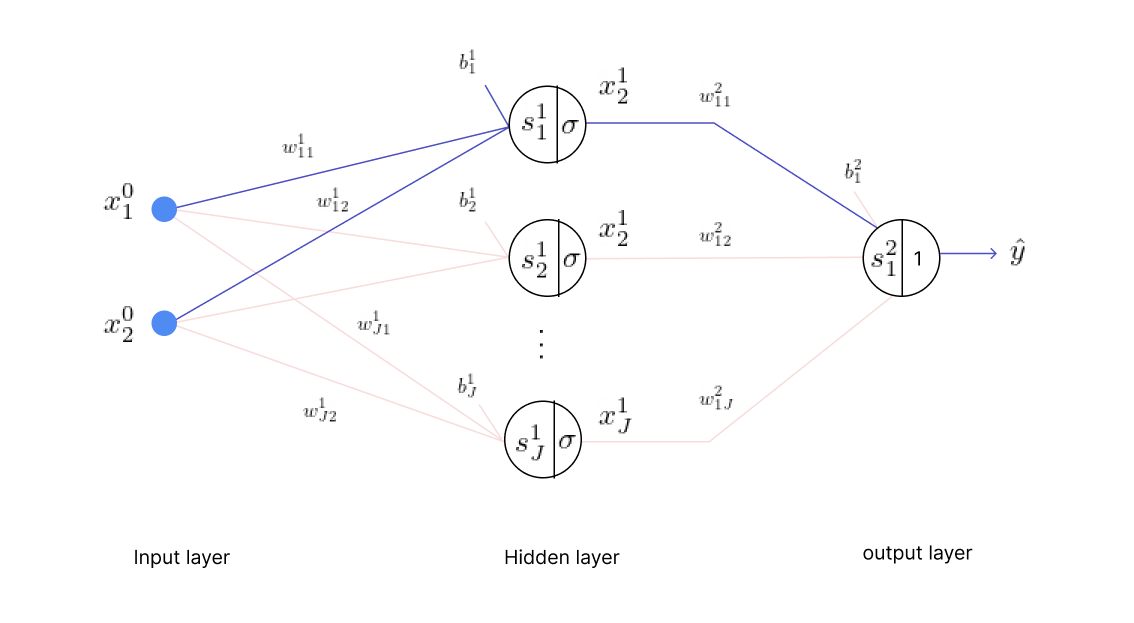

In [38]:
# training data

xs = df[['X1', 'X2']].to_numpy()
ys = df['Y'].to_numpy()
ys = ys.reshape(-1,1)

rng = np.random.default_rng(seed=0)

net = Sequential([
    Linear(input_dim=2, output_dim=4, w=rng.normal(loc=0, scale =0.5, size=(4,2)), b = rng.normal(loc=0, scale =0.5, size=4)) ,
    Sigmoid(),
    Linear(input_dim=4, output_dim=1, w=rng.normal(loc=0, scale =0.66, size=(1,4)), b = rng.normal(loc=0, scale =1, size=1))
])

In [39]:
optimizer = GradientDescent(lr=0.1)
loss = SSE()

In [40]:
with tqdm.trange(100) as t:
  for epoch in t:
    epoch_loss = 0.0

    for x,y in zip(xs, ys):
      predicted = net.forward(x)
      epoch_loss += loss.loss(predicted, y)
      gradient = loss.gradient(predicted, y)
      net.backward(gradient)

      optimizer.step(net)

    t.set_description(f'xor loss {epoch_loss:.3f}')

xor loss 384.706: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


In [41]:
for param in net.params():
  print(param, '\n')

[[ -8.87831568   0.05787374]
 [  0.88338976   7.19846607]
 [-13.35185566  -0.054573  ]
 [ -0.99287345   6.81896623]] 

[ -0.31664255  -3.75493427 -11.28519111   3.26729819] 

[[-5.51984487 -3.72982054  3.28012018  4.35060279]] 

[0.21056711] 



In [42]:
# Prediction using the trained network

output=[]

for x in xs:
    output.append(net.forward(x)[0])

In [43]:
df['y_pred'] = output
df.head()

,X1,X2,Y,y_pred
0,0.304599,-0.783155,1.058676,0.334506
1,-0.912449,0.462159,-0.544019,0.513127
2,-0.959941,0.099209,2.007910,1.630290
3,0.678425,-0.323466,3.878022,2.777696
4,0.174286,0.735970,0.095776,0.638983
